In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

***Loading Dataset**

In [34]:
df = pd.read_csv('/content/PHAC_Data.csv')
df.head()


,Geography,Sex,Age group type,Age group,Fiscal year,Prevalence (%),Standard Error,Lower 95%_CI,Upper 95%_CI,Rate CV (%),Counts,Population
0,Canada,Both sexes,Total,1+,2000–2001,4.20,0.0,4.19,4.21,0.09,1285180.0,30595365.0
1,Canada,Both sexes,Life course,1–19,2000–2001,0.22,0.0,0.22,0.23,0.78,16485.0,7395470.0
2,Canada,Both sexes,5 Year,1–4,2000–2001,0.06,0.0,0.06,0.07,3.42,855.0,1385590.0
3,Canada,Both sexes,5 Year,5–9,2000–2001,0.15,0.0,0.15,0.16,1.82,3005.0,1974630.0
4,Canada,Both sexes,5 Year,10–14,2000–2001,0.25,0.0,0.25,0.26,1.39,5145.0,2021675.0


## Data formatting and cleaning

In [35]:
# Convert fiscal year to datetime format
df['Fiscal year'] = pd.to_datetime(df['Fiscal year'].str[-4:], format='%Y')

In [36]:
# removing missing values

missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

df_clean = df.dropna()

Missing Values:
 Geography            0
Sex                  0
Age group type       0
Age group            0
Fiscal year          0
Prevalence (%)    1077
Standard Error    1077
Lower 95%_CI      1077
Upper 95%_CI      1077
Rate CV (%)       1077
Counts            1077
Population        1077
dtype: int64


In [37]:
# Checking dataset after removing duplicates

df_clean.describe()

,Fiscal year,Prevalence (%),Standard Error,Lower 95%_CI,Upper 95%_CI,Rate CV (%),Counts,Population
count,6645,6645.000000,6645.000000,6645.000000,6645.000000,6645.000000,6.645000e+03,6.645000e+03
mean,2011-12-09 10:05:02.302483200,10.459264,0.143783,10.187151,10.761863,2.091281,8.554429e+04,1.151782e+06
min,2001-01-01 00:00:00,0.050000,0.000000,0.040000,0.050000,0.050000,1.000000e+01,6.500000e+01
25%,2007-01-01 00:00:00,1.290000,0.010000,1.220000,1.360000,0.370000,2.515000e+03,7.194000e+04
50%,2012-01-01 00:00:00,7.210000,0.040000,7.090000,7.290000,0.850000,1.396000e+04,3.738650e+05
75%,2017-01-01 00:00:00,18.130000,0.110000,17.440000,18.570000,1.990000,7.229500e+04,1.174125e+06
max,2022-01-01 00:00:00,38.100000,6.020000,37.030000,51.870000,31.620000,3.663300e+06,3.907124e+07
std,NaN,9.881204,0.428363,9.653951,10.210053,3.720238,2.325249e+05,2.833496e+06


In [6]:
# Checking for duplicates

duplicates = df_clean.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


In [38]:
# Filter the dataset for Ontario
df_ontario = df_clean[df_clean['Geography'] == 'Ontario']


# Check if data is loaded correctly
df_ontario.head()

,Geography,Sex,Age group type,Age group,Fiscal year,Prevalence (%),Standard Error,Lower 95%_CI,Upper 95%_CI,Rate CV (%),Counts,Population
4026,Ontario,Both sexes,Total,1+,2001-01-01,4.44,0.01,4.43,4.45,0.14,545715.0,12286085.0
4027,Ontario,Both sexes,Life course,1–19,2001-01-01,0.24,0.00,0.24,0.25,1.16,7410.0,3047305.0
4028,Ontario,Both sexes,Life course,20–34,2001-01-01,0.87,0.01,0.86,0.88,0.67,22285.0,2565970.0
4029,Ontario,Both sexes,Life course,35–49,2001-01-01,2.76,0.01,2.74,2.77,0.34,85815.0,3113560.0
4030,Ontario,Both sexes,Life course,50–64,2001-01-01,8.97,0.02,8.93,9.01,0.24,175235.0,1953205.0


In [39]:
# Remove rows with missing prevalence data
df_ontario.dropna(subset=['Prevalence (%)'], inplace=True)

# Filter for the 'Total' age group type for simplicity in initial analysis
df_ontario_total = df_ontario[df_ontario['Age group type'] == 'Total']
df_ontario = df_ontario[df_ontario['Age group type'] == 'Life course']

# Check the cleaned data
#df_ontario_total.head()

<ipython-input-39-d39d25f753f4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ontario.dropna(subset=['Prevalence (%)'], inplace=True)


# EDA

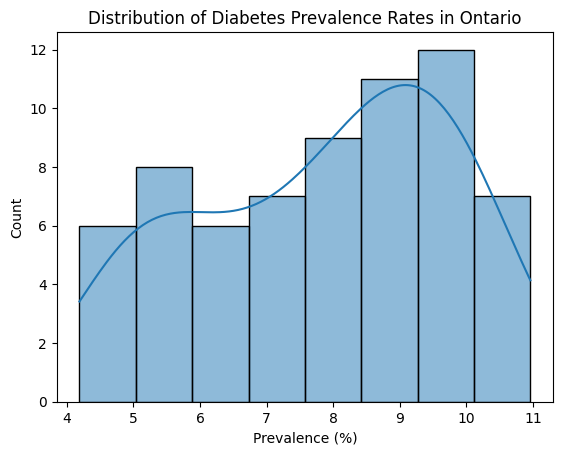

In [40]:
# Basic descriptive statistics
#print(df_ontario_total.describe())

# Plot the distribution of prevalence rates
sns.histplot(df_ontario_total['Prevalence (%)'], kde=True)
plt.title('Distribution of Diabetes Prevalence Rates in Ontario')
plt.show()


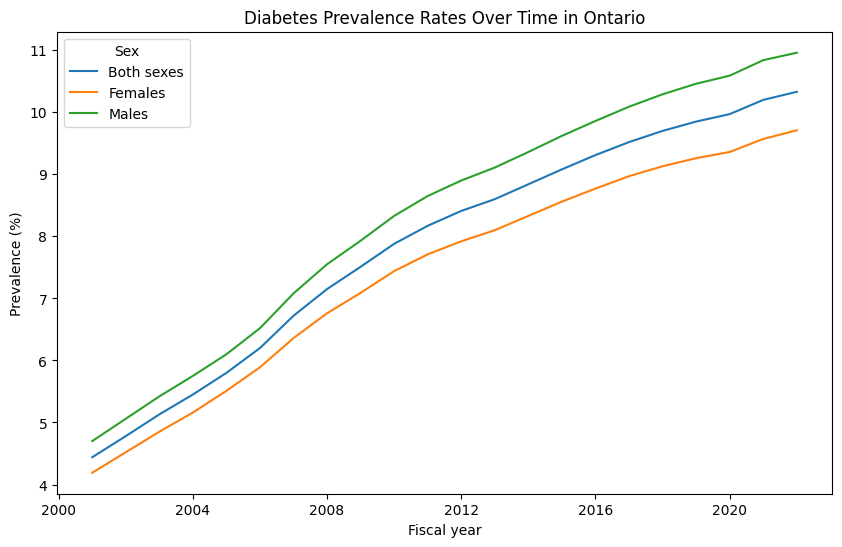

In [41]:
# Time series plot of diabetes prevalence rates over time
plt.figure(figsize=(10,6))
sns.lineplot(x='Fiscal year', y='Prevalence (%)', data=df_ontario_total, hue='Sex')
plt.title('Diabetes Prevalence Rates Over Time in Ontario')
plt.show()

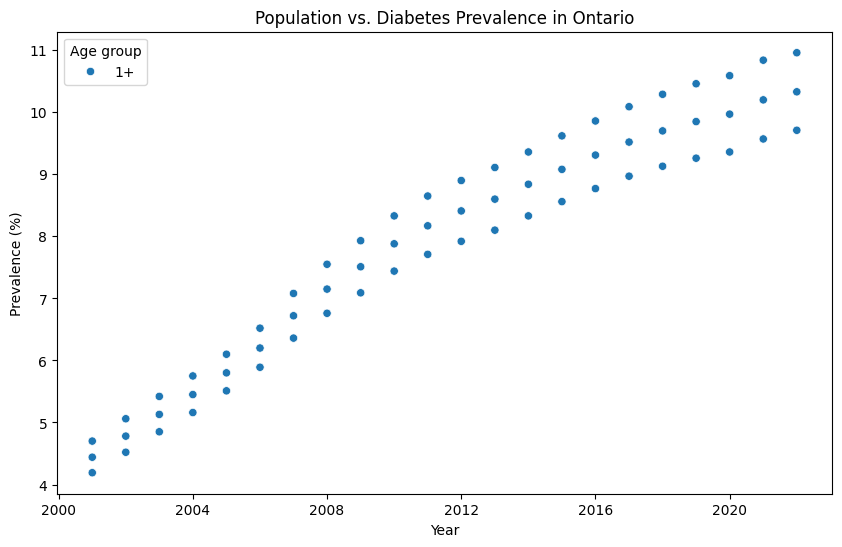

In [42]:
# Scatter plot of Population vs. Diabetes Prevalence
plt.figure(figsize=(10,6))
sns.scatterplot(x='Fiscal year', y='Prevalence (%)', hue='Age group', data=df_ontario_total)
plt.title('Population vs. Diabetes Prevalence in Ontario')
plt.xlabel('Year')
plt.ylabel('Prevalence (%)')
plt.show()


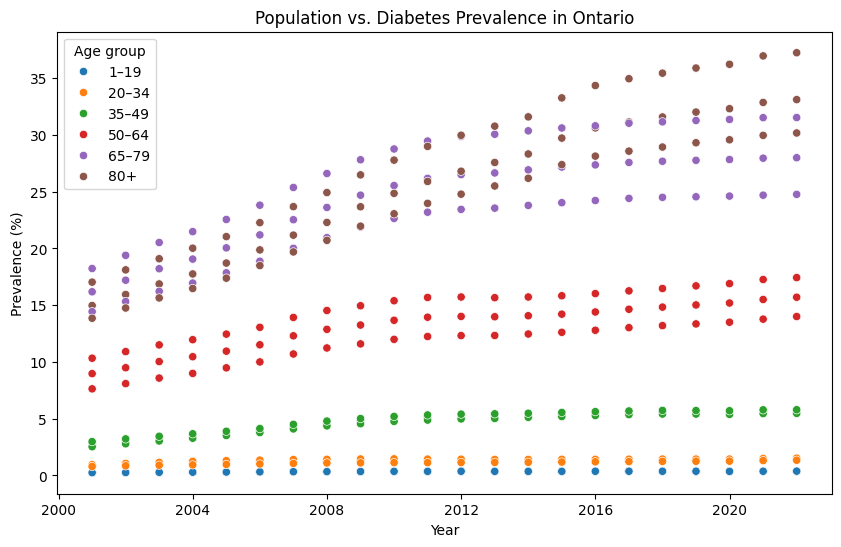

In [12]:
 # Scatter plot of Population vs. Diabetes Prevalence
plt.figure(figsize=(10,6))
sns.scatterplot(x='Fiscal year', y='Prevalence (%)', hue='Age group', data=df_ontario)
plt.title('Population vs. Diabetes Prevalence in Ontario')
plt.xlabel('Year')
plt.ylabel('Prevalence (%)')
plt.show()


In [13]:
# Filter the data for total (1+) age group, both sexes
df_total = df[(df['Age group'] == '1+') & (df['Sex'] == 'Both sexes')]

# Get the first and last year from the dataset
first_year = df_total['Fiscal year'].min()
last_year = df_total['Fiscal year'].max()

# Filter data for the first and last years
df_first_year = df_total[df_total['Fiscal year'] == first_year]
df_last_year = df_total[df_total['Fiscal year'] == last_year]

# Create a combined DataFrame for the first and last year
df_combined = pd.concat([df_first_year, df_last_year])

# Add a column to indicate which year the data belongs to
df_combined['Year'] = df_combined['Fiscal year'].dt.year


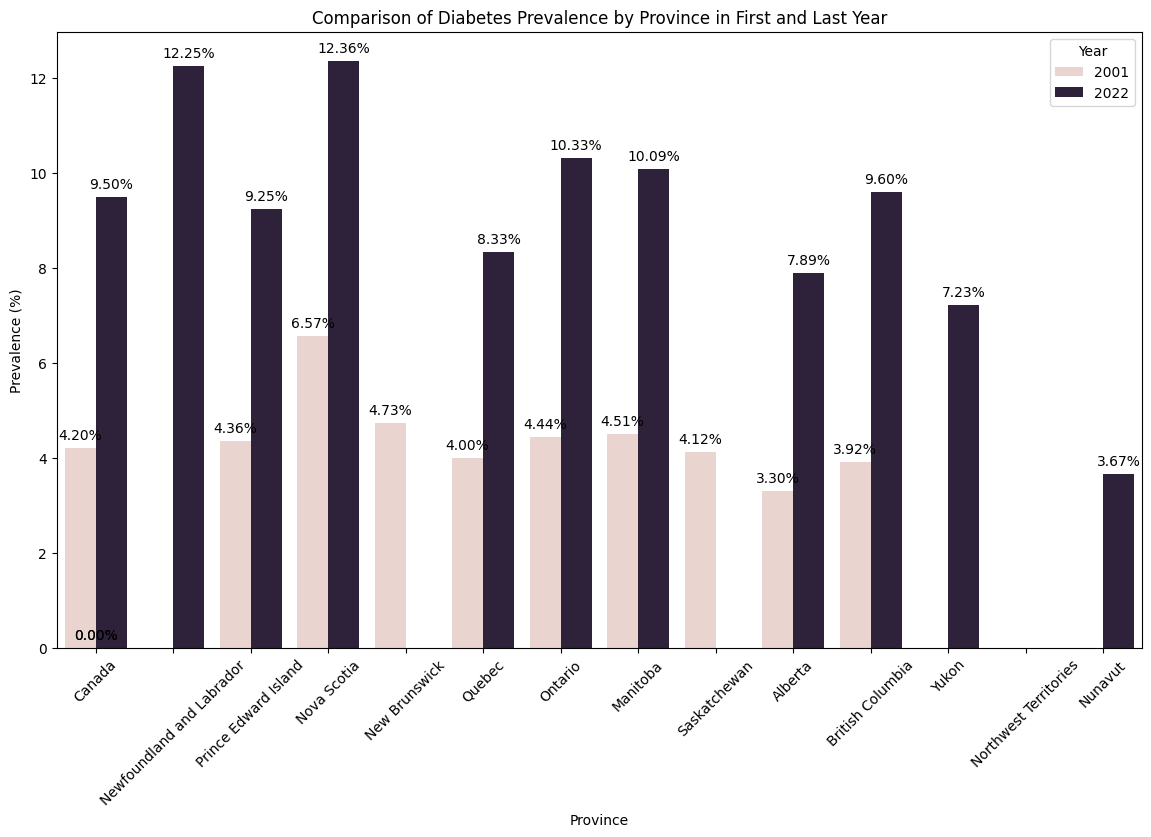

In [14]:


# Create the bar plot
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='Geography', y='Prevalence (%)', hue='Year', data=df_combined)

# Annotate the bars with the percentage values
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.title('Comparison of Diabetes Prevalence by Province in First and Last Year')
plt.ylabel('Prevalence (%)')
plt.xlabel('Province')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.show()

In [15]:
# Calculate the difference in prevalence between the last year and the first year
df_diff = df_last_year[['Geography', 'Prevalence (%)']].set_index('Geography')
df_diff.columns = ['Last Year Prevalence (%)']

df_diff['First Year Prevalence (%)'] = df_first_year.set_index('Geography')['Prevalence (%)']
df_diff['Difference (%)'] = df_diff['Last Year Prevalence (%)'] - df_diff['First Year Prevalence (%)']

# Sort by the largest difference
df_diff_sorted = df_diff.sort_values(by='Difference (%)', ascending=False)

# Display the sorted table
df_diff_sorted.reset_index(inplace=True)
print(df_diff_sorted)

                    Geography  Last Year Prevalence (%)  \
0                     Ontario                     10.33   
1                 Nova Scotia                     12.36   
2            British Columbia                      9.60   
3                    Manitoba                     10.09   
4                      Canada                      9.50   
5        Prince Edward Island                      9.25   
6                     Alberta                      7.89   
7                      Quebec                      8.33   
8   Newfoundland and Labrador                     12.25   
9               New Brunswick                       NaN   
10               Saskatchewan                       NaN   
11                      Yukon                      7.23   
12      Northwest Territories                       NaN   
13                    Nunavut                      3.67   

    First Year Prevalence (%)  Difference (%)  
0                        4.44            5.89  
1                 

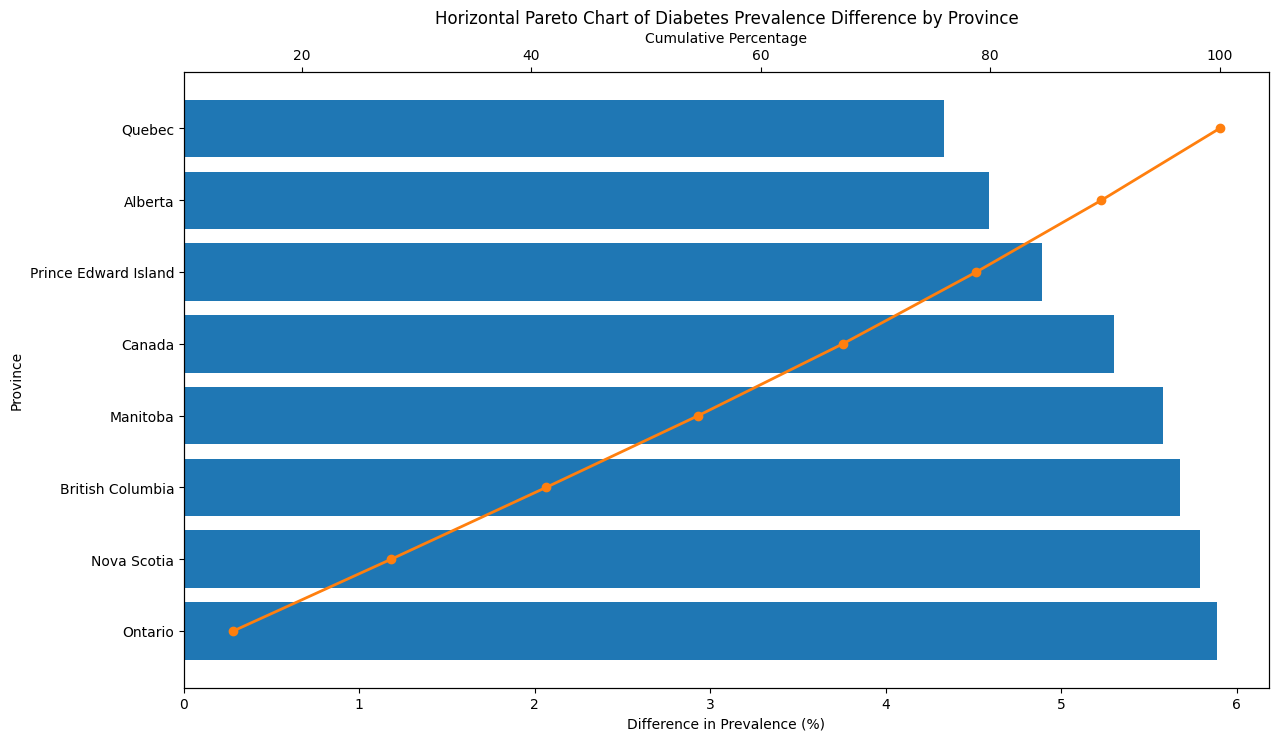

In [16]:
# Calculate cumulative percentage for Pareto chart
df_diff_sorted['Cumulative Percentage'] = df_diff_sorted['Difference (%)'].cumsum() / df_diff_sorted['Difference (%)'].sum() * 100

# Plot the horizontal Pareto chart
fig, ax1 = plt.subplots(figsize=(14,8))

# Horizontal bar plot for the increase in prevalence
ax1.barh(df_diff_sorted['Geography'], df_diff_sorted['Difference (%)'], color='C0')
ax1.set_ylabel('Province')
ax1.set_xlabel('Difference in Prevalence (%)')
ax1.set_title('Horizontal Pareto Chart of Diabetes Prevalence Difference by Province')

# Line plot for the cumulative percentage
ax2 = ax1.twiny()
ax2.plot(df_diff_sorted['Cumulative Percentage'], df_diff_sorted['Geography'], color='C1', marker='o', linestyle='-', linewidth=2)
ax2.set_xlabel('Cumulative Percentage')

# Show the plot
plt.show()


# **Encoding**

## Before encoding lets format Age group columns

In [43]:
df_ontario = df_ontario[df_ontario['Sex'] != 'Both sexes']

In [44]:
# Strip any leading or trailing whitespace from the 'Age group' column
df_ontario['Age group'] = df_ontario['Age group'].str.strip()

# Convert the 'Age group' column to a consistent string data type
df_ontario['Age group'] = df_ontario['Age group'].astype(str)

# Verify the changes
print(df_ontario['Age group'].unique())

['1–19' '20–34' '35–49' '50–64' '65–79' '80+']


In [45]:
# Check the unique values in the Age group column
unique_age_groups = df_ontario['Age group'].unique()
print("Unique age groups in the data:", unique_age_groups)

# Update the age_group_mapping dictionary
age_group_mapping = {
    '1–19': 1,
    '20–34': 2,
    '35–49': 3,
    '50–64': 4,
    '65–79': 5,
    '80+': 6,
    'Total': 7  # Add any missing or additional age groups here
}

# Map the age groups to their corresponding encoded values
df_ontario['Age_group_encoded'] = df_ontario['Age group'].map(age_group_mapping)

# Check for any remaining NaN values after mapping
print("Number of NaN values in Age_group_encoded:", df_ontario['Age_group_encoded'].isna().sum())


Unique age groups in the data: ['1–19' '20–34' '35–49' '50–64' '65–79' '80+']
Number of NaN values in Age_group_encoded: 0


### encoding sex column

In [46]:
# Encoding 'Sex' to include 'Both sexes' with a distinct value
sex_mapping = {
    'Males': 0,
    'Females': 1,
    'Both sexes': 2
}

df_ontario['Sex_encoded'] = df_ontario['Sex'].map(sex_mapping)
df_ontario['Sex_encoded'].isna().sum()

0

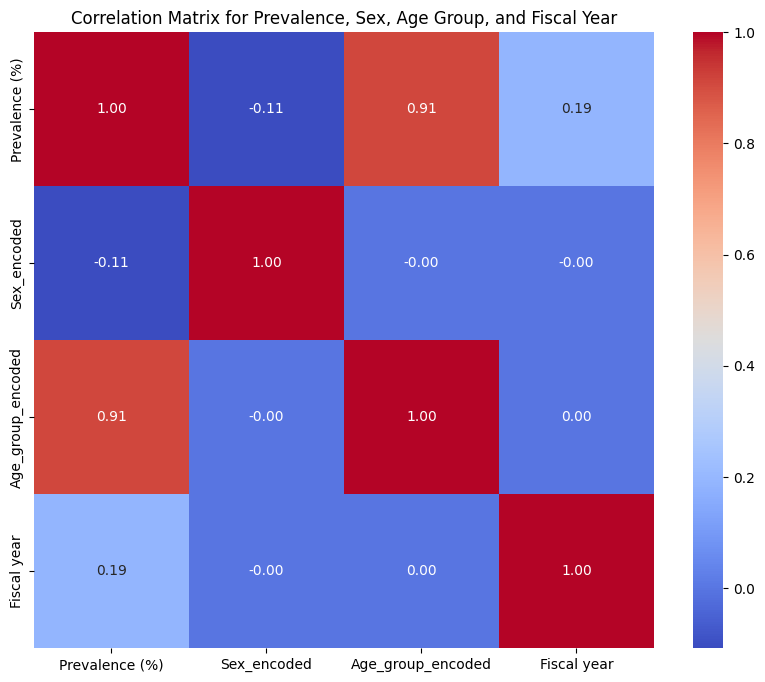

In [21]:


# Select the relevant columns for correlation
correlation_columns = ['Prevalence (%)', 'Sex_encoded', 'Age_group_encoded', 'Fiscal year']

# Create the correlation matrix
correlation_matrix = df_ontario[correlation_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Prevalence, Sex, Age Group, and Fiscal Year')
plt.show()


## Anova Matrix

In [22]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# ANOVA for 'Age group' and 'Sex'
anova_both = ols('Q("Prevalence (%)") ~ C(Age_group_encoded) + C(Sex_encoded)', data=df_ontario).fit()
anova_table_both = sm.stats.anova_lm(anova_both, typ=2)

# Display the ANOVA table with formatting
print(anova_table_both.to_string(float_format="{:.3f}".format))


                        sum_sq      df       F  PR(>F)
C(Age_group_encoded) 28849.470   5.000 517.282   0.000
C(Sex_encoded)         373.422   1.000  33.478   0.000
Residual              2866.645 257.000     NaN     NaN


### 1. ANOVA for Age_group_encoded:
Sum of Squares (sum_sq): This shows the variability explained by the age group categories (28849.47) and the residual error (3240.07).

Degrees of Freedom (df): The degrees of freedom for the Age_group_encoded is 5, which is correct since there are 6 age groups (1+ included). The residual degrees of freedom is 258, corresponding to the total number of observations minus the number of categories.

F-Statistic (F): The F-value is extremely high (459.45), indicating that the variability between the age groups is much larger than the variability within the groups (residual).

P-Value (PR(>F)): The p-value is extremely low (3.31e-126), effectively zero, which indicates that the differences between the age groups are statistically significant.
Conclusion: The age groups significantly influence the prevalence of diabetes, which aligns with what you'd expect given the strong correlation seen in the earlier correlation matrix.

### 2. ANOVA for Sex_encoded:
Sum of Squares (sum_sq): The sum of squares for sex (373.42) is much smaller compared to age group, meaning sex explains far less of the variability in diabetes prevalence.

Degrees of Freedom (df): Here, Sex_encoded has 1 degree of freedom, which is expected since it's a binary/ternary variable.

F-Statistic (F): The F-value is 3.08, which is relatively low compared to the age group F-value, suggesting less distinction between the categories of sex regarding diabetes prevalence.

P-Value (PR(>F)): The p-value (0.080197) is above the typical significance threshold of 0.05, suggesting that the difference in diabetes prevalence between sexes is not statistically significant.
Conclusion: The sex of the individuals does not significantly impact diabetes prevalence in your dataset, aligning with the weak correlation seen previously.

# Time series anlaysis

In [51]:
# Ensure 'Fiscal year' is your time index
df_ontario.index = pd.to_datetime(df_ontario.index, format='%Y')


# Aggregate the data by year, sex, and age group
# You can use mean or sum depending on what you want to analyze
# Here we use mean to keep the prevalence data normalized
# Include only numeric columns in the mean calculation
df_ts = df_ontario.groupby(['Fiscal year', 'Sex', 'Age group'])['Prevalence (%)'].mean().reset_index()

# Convert 'Fiscal year' back to datetime if it gets reset during operations
df_ts['Fiscal year'] = pd.to_datetime(df_ts['Fiscal year'])

# Check the structure of the prepared dataframe
print(df_ts.head())

  Fiscal year      Sex Age group  Prevalence (%)
0  2001-01-01  Females      1–19            0.24
1  2001-01-01  Females     20–34            0.95
2  2001-01-01  Females     35–49            2.53
3  2001-01-01  Females     50–64            7.63
4  2001-01-01  Females     65–79           14.43


In [52]:
# Pivot the table so that each combination of 'Sex' and 'Age group' forms a separate column
df_ts_pivot = df_ts.pivot_table(index='Fiscal year', columns=['Sex', 'Age group'], values='Prevalence (%)')

# Inspect the pivoted data
print(df_ts_pivot.head())


Sex         Females                                 Males                     \
Age group      1–19 20–34 35–49 50–64  65–79    80+  1–19 20–34 35–49  50–64   
Fiscal year                                                                    
2001-01-01     0.24  0.95  2.53  7.63  14.43  13.85  0.25  0.79  2.98  10.33   
2002-01-01     0.26  1.06  2.79  8.09  15.32  14.75  0.26  0.85  3.22  10.91   
2003-01-01     0.27  1.15  3.04  8.58  16.22  15.64  0.28  0.90  3.45  11.50   
2004-01-01     0.29  1.24  3.28  8.99  16.95  16.47  0.29  0.93  3.67  11.96   
2005-01-01     0.30  1.30  3.52  9.48  17.85  17.38  0.30  0.97  3.89  12.45   

Sex                        
Age group    65–79    80+  
Fiscal year                
2001-01-01   18.23  17.03  
2002-01-01   19.39  18.11  
2003-01-01   20.52  19.09  
2004-01-01   21.48  20.02  
2005-01-01   22.55  21.04  


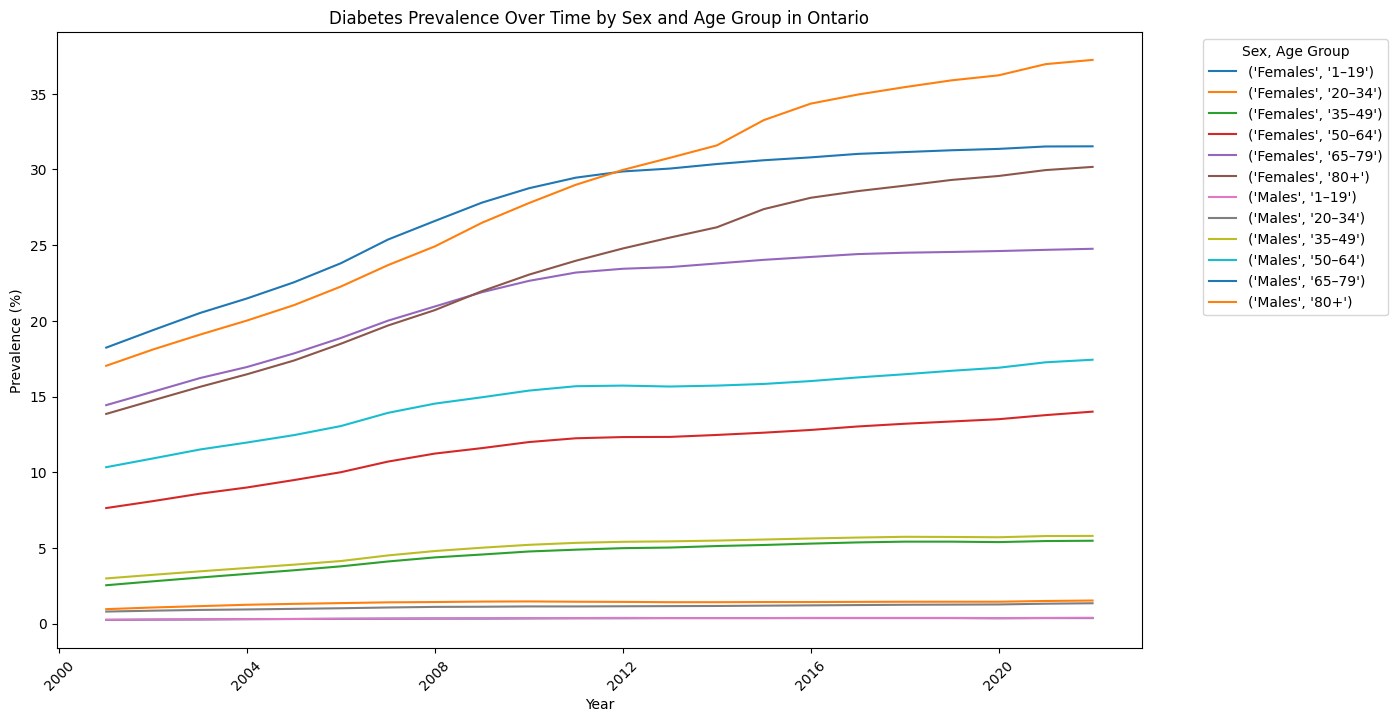

In [53]:
import matplotlib.pyplot as plt

# Plot the time series data
plt.figure(figsize=(14, 8))

# Plot each time series
for column in df_ts_pivot.columns:
    plt.plot(df_ts_pivot.index, df_ts_pivot[column], label=column)

plt.title('Diabetes Prevalence Over Time by Sex and Age Group in Ontario')
plt.ylabel('Prevalence (%)')
plt.xlabel('Year')
plt.legend(title='Sex, Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


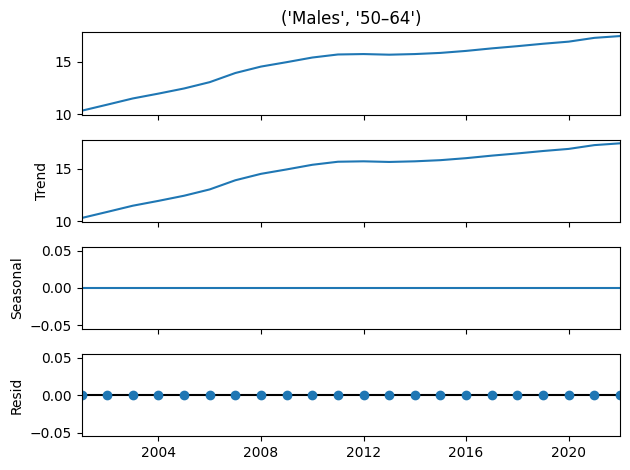

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series for a specific combination (e.g., 'Males' and '50-64' age group)
ts_decomposition = seasonal_decompose(df_ts_pivot['Males', '50–64'], model='additive')

# Plot the decomposed components
ts_decomposition.plot()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


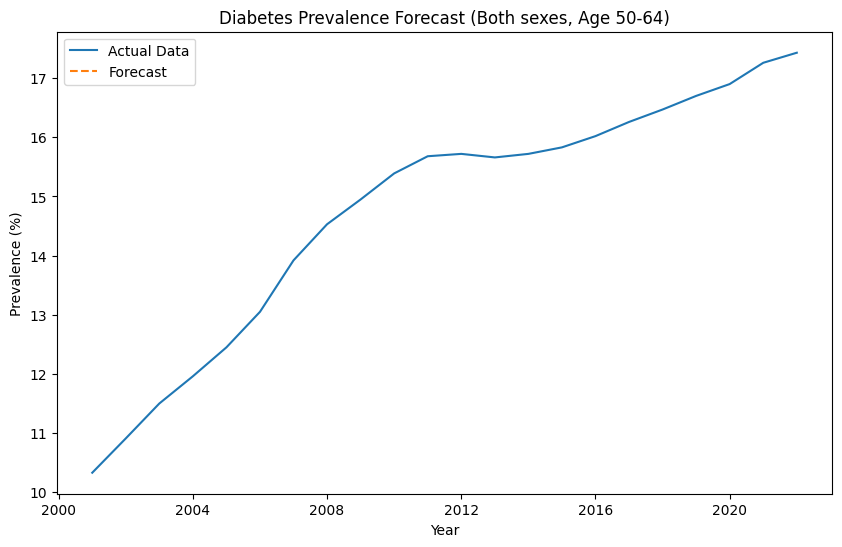

In [59]:
from statsmodels.tsa.arima.model import ARIMA

# Choose a specific time series to forecast (e.g., 'Both sexes', '50-64' age group)
time_series = df_ts_pivot['Males', '50–64']

# Fit the ARIMA model
model_arima = ARIMA(time_series, order=(1,1,1))
model_fit = model_arima.fit()

# Forecast the next 5 periods (years)
forecast = model_fit.get_forecast(steps=5)
forecast_index = pd.date_range(start=time_series.index[-1], periods=5, freq='A')

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecast'])

# Plot the actual data and forecast
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Actual Data')
plt.plot(forecast_df, label='Forecast', linestyle='--')
plt.title('Diabetes Prevalence Forecast (Both sexes, Age 50-64)')
plt.ylabel('Prevalence (%)')
plt.xlabel('Year')
plt.legend()
plt.show()


<Figure size 1200x800 with 0 Axes>

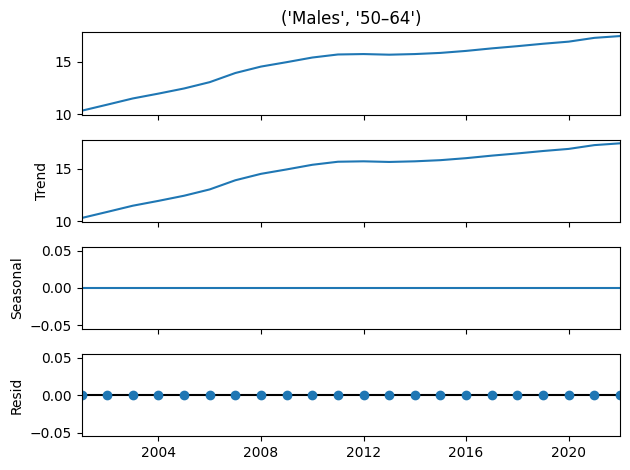

<Figure size 1200x800 with 0 Axes>

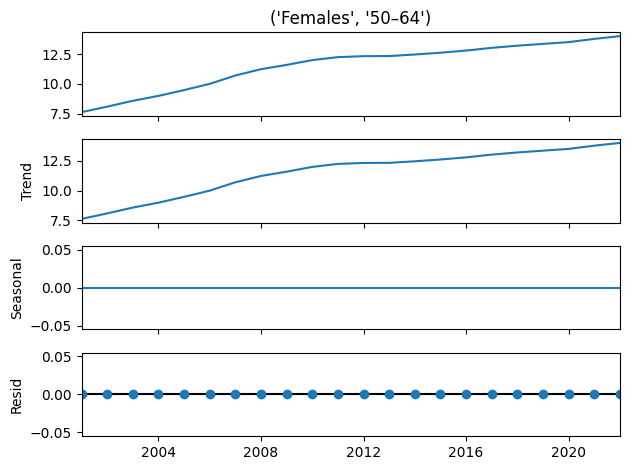

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series for Males
ts_decomposition_male = seasonal_decompose(df_ts_pivot['Males', '50–64'], model='additive')

# Plot the decomposed components for Males
plt.figure(figsize=(12, 8))
plt.suptitle('Time Series Decomposition - Males (Age 50–64)')
ts_decomposition_male.plot()
plt.show()

# Decompose the time series for Females
ts_decomposition_female = seasonal_decompose(df_ts_pivot['Females', '50–64'], model='additive')

# Plot the decomposed components for Females
plt.figure(figsize=(12, 8))
plt.suptitle('Time Series Decomposition - Females (Age 50–64)')
ts_decomposition_female.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


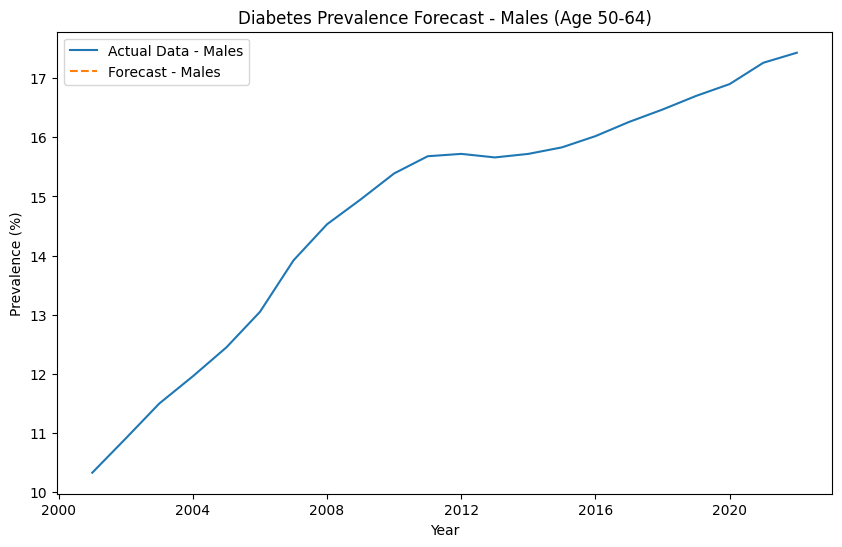

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


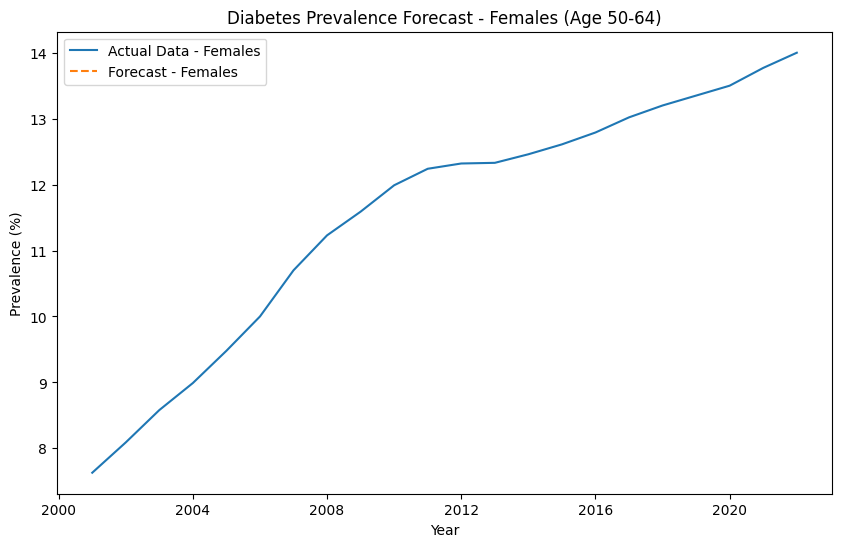

In [63]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model for Males (Age 50-64)
model_arima_male = ARIMA(df_ts_pivot['Males', '50–64'], order=(1,1,1))
model_fit_male = model_arima_male.fit()

# Forecast the next 5 years for Males
forecast_male = model_fit_male.get_forecast(steps=5)
forecast_index_male = pd.date_range(start=df_ts_pivot.index[-1], periods=5, freq='A')

# Convert forecast to DataFrame for Males
forecast_df_male = pd.DataFrame(forecast_male.predicted_mean, index=forecast_index_male, columns=['Forecast'])

# Plot the actual data and forecast for Males
plt.figure(figsize=(10, 6))
plt.plot(df_ts_pivot['Males', '50–64'], label='Actual Data - Males')
plt.plot(forecast_df_male, label='Forecast - Males', linestyle='--')
plt.title('Diabetes Prevalence Forecast - Males (Age 50-64)')
plt.ylabel('Prevalence (%)')
plt.xlabel('Year')
plt.legend()
plt.show()

# Fit ARIMA model for Females (Age 50-64)
model_arima_female = ARIMA(df_ts_pivot['Females', '50–64'], order=(1,1,1))
model_fit_female = model_arima_female.fit()

# Forecast the next 5 years for Females
forecast_female = model_fit_female.get_forecast(steps=5)
forecast_index_female = pd.date_range(start=df_ts_pivot.index[-1], periods=5, freq='A')

# Convert forecast to DataFrame for Females
forecast_df_female = pd.DataFrame(forecast_female.predicted_mean, index=forecast_index_female, columns=['Forecast'])

# Plot the actual data and forecast for Females
plt.figure(figsize=(10, 6))
plt.plot(df_ts_pivot['Females', '50–64'], label='Actual Data - Females')
plt.plot(forecast_df_female, label='Forecast - Females', linestyle='--')
plt.title('Diabetes Prevalence Forecast - Females (Age 50-64)')
plt.ylabel('Prevalence (%)')
plt.xlabel('Year')
plt.legend()
plt.show()


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Prepare the dataset
df_ontario['Year'] = df_ontario.index.year
X = df_ontario[['Year', 'Sex_encoded', 'Age_group_encoded']]
y = df_ontario['Prevalence (%)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

# Predict prevalence for a new example
new_data = pd.DataFrame({
    'Year': [2025],
    'Sex_encoded': [0],  # Male
    'Age_group_encoded': [4]  # 50–64 age group
})
predicted_prevalence = model.predict(new_data)
print(f'Predicted Prevalence: {predicted_prevalence[0]:.2f}%')


Mean Absolute Error: 3.35
Predicted Prevalence: 19.99%
